# KWExtractor miscellanious

In [1]:
# Some miscellaneous procedures
# ---- Normalization of text with NLTK (tokenization -> choosing nouns and adjectives with pos-tagging -> filtering stop-words)
# ---- Build graph of words (undirected)
# ---- Basic draw
# ---- Community Draw

# Necessary imports
import nltk
import numpy as np
import re
from nltk.tokenize import RegexpTokenizer
import collections

import networkx as nx
import scipy.sparse as sps    
import matplotlib.pyplot as plt
import matplotlib

import community #python-louvain, download and install it externally



def NormalizeTextFromRaw(rawText):
	#IN raw text
	#OUT extracted words, normalized original nltk.Text (tokenized,lowercased)

	rawText = re.sub(r'\d+', '', rawText)
	tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(rawText)

	postags = nltk.pos_tag(tokens) 
	#print(postags)
	text= nltk.Text(tokens)
	words = [w.lower() for w in text]

	return (GetWordsFromText(words,postags),words)   #wordList, text

def GetWordsFromText(words,postags):
	#Gets the wordList	
	#print(len(words))
	wordList = [words[k] for k in np.arange(len(words)) if ((postags[k][1].find("JJ")>=0) or (postags[k][1].find("NN")>=0))]
	#print(len(wordList))
	wordList=np.unique(wordList)
	#print(len(wordList))
	wordList = np.array([word for word in wordList if word not in set(nltk.corpus.stopwords.words('english'))])
	#print(wordList.shape)
	return wordList


def BuildUndirectedGoW(txt,words,window=2): 
	#Builds undirected graph of words
	#IN:    nltk.Text txt -- text to be processed,
	#	nltk.Text words -- filtered wordList
	#	int window -- sliding window
	#OUT:	sps.Csr_Matrix Adj_mat -- adjacency matrix

	Adj_mat = sps.lil_matrix((len(words),len(words)),dtype="float64")

	for i in np.arange(len(txt)):
		src=np.where(words[:]==txt[i])
		if(len(src)>0):   
			for j in np.arange(i+1,np.min([i+window,len(txt)])):
				dest=np.where(words[:]==txt[j])
				if(len(dest)>0):
					if(not src == dest):
						try:
							Adj_mat[src,dest]=Adj_mat[src,dest]+1
							Adj_mat[dest,src]=Adj_mat[dest,src]+1#undirected graph
						except:
							Adj_mat[src,dest]=1
							Adj_mat[dest,src]=1
                    
        
	Adj_mat = sps.csr_matrix(Adj_mat)
	return Adj_mat


def BasicDraw(G,labs,title=""):
	#Just draws graph of Words (undirected)
	#IN: nx.Graph G, list<string> labs -- list of labels assigned to nodes
	
	N=len(G.nodes)#number of nodes

	f, ax = plt.subplots(figsize=(12,12)) #is not returned TODO think about it
	ax.set_title(title)

	pos=nx.spring_layout(G, k= 1/np.sqrt(N)*35,iterations=710,weight=0.1) # positions for all nodes, parameters are purely experimental
										#TODO check if you can change it
	nx.draw_networkx_nodes(G,pos,
                       node_list=labs,
                       node_color='r', 
                       node_size=20,
                   alpha=0.8)

	# edges
	nx.draw_networkx_edges(G,pos,width=0.5,arrows=False,alpha=0.5)

	# labels
	#print(G.nodes)
	nx.draw_networkx_labels(G,pos,dict(zip(G.nodes,labs)),font_size=9)


def LouvainCommunitiesPlot(G,labels,title=""):

	communities = community.best_partition(G)

	cmap_tab20 = plt.get_cmap("tab20")

	f, ax = plt.subplots(figsize=(12,12))
	ax.set_title(title)

	pos=nx.spring_layout(G, k= 1/np.sqrt(len(G.nodes))*35,iterations=710,weight=0.1) # positions for all nodes


	for com_id in set(communities.values()) :
		list_nodes = [nodes for nodes in communities.keys()
			if communities[nodes] == com_id]
		nx.draw_networkx_nodes(G, pos, list_nodes, node_size = len(list_nodes)**2*20,
				node_color = ""+matplotlib.colors.to_hex(cmap_tab20(com_id)))
    
	nx.draw_networkx_edges(G,pos,width=0.5,arrows=False,alpha=0.5)
	nx.draw_networkx_labels(G,pos,dict(zip(G.nodes,list(labels))),font_size=9)

	return communities #in python-louvain format

# kwextractor_methods

In [2]:
#Methods for keyword extraction

# Necessary imports
import numpy as np
import scipy.sparse as sps
import networkx as nx
#import kwextractor_miscellaneous as kwmisc #import the module
import collections
import community

def kCoreLouvainExtractor(raw,window=3, verbose=False):
	
	(words,txt)=NormalizeTextFromRaw(raw)
	#print(txt)
	#print(words)
	gow_adj = BuildUndirectedGoW(txt,words, window=window)
	gow = nx.Graph(gow_adj)	

	if(verbose):
		BasicDraw(gow,words,"InitialGoW")
	#kcore
	kcore=nx.algorithms.core.k_core(gow)
	if(verbose):
		BasicDraw(kcore, list(words[kcore.nodes]), "Kcore (main)")
		
	#Louvain communities
	communities=[] # just init
	if(verbose):
		communities=LouvainCommunitiesPlot(kcore,words[list(kcore.nodes)], "Louvain communities")
	else:
		communities = community.best_partition(kcore)	

	counterObj = collections.Counter(communities.values())
	kwdCluster_id= counterObj.most_common(1)[0][0]
	#print(kwdCluster_id)
	#print(np.array(list(communities.values())))
	#print(np.where(np.array(list(communities.values()))==kwdCluster_id))
	#print(np.array(list(communities.keys()))[np.where(np.array(list(communities.values()))==kwdCluster_id)])
	kwds = words[np.array(list(communities.keys()))[np.where(np.array(list(communities.values()))==kwdCluster_id)]]
	
	return kwds

# build matrix and apply algorithm

247
['ablan' 'account' 'advisers' 'analysts' 'asr' 'asset' 'auction' 'bitcoin'
 'bitstamp' 'blockchain' 'bogart' 'brand' 'brendan' 'brokers' 'cameron'
 'campos' 'capital' 'catalyst' 'caution' 'cboe' 'chanel' 'chavez' 'chicago'
 'class' 'closing' 'cme' 'contract' 'contracts' 'contrast' 'cooney' 'copy'
 'cryptocurrency' 'cryptography' 'currency' 'dado' 'debut' 'dec' 'demand'
 'deposit' 'derivatives' 'dreyfuss' 'editing' 'entrepreneurs' 'entry'
 'exchange' 'exchanges' 'experts' 'february' 'file' 'fund' 'futures'
 'gemini' 'gertrude' 'giant' 'global' 'group' 'half' 'high' 'higher' 'hour'
 'illustration' 'inc' 'individual' 'intermediaries' 'introduction'
 'investors' 'january' 'jennifer' 'june' 'launch' 'legitimacy' 'limits'
 'llc' 'lot' 'man' 'manager' 'march' 'margin' 'margins' 'market' 'markets'
 'mcdermid' 'melbourne' 'min' 'month' 'motherboard' 'nakamoto' 'new'
 'october' 'offices' 'order' 'p' 'pandey' 'partner' 'path' 'pc' 'percent'
 'peter' 'photo' 'picture' 'pressure' 'price' 'rally

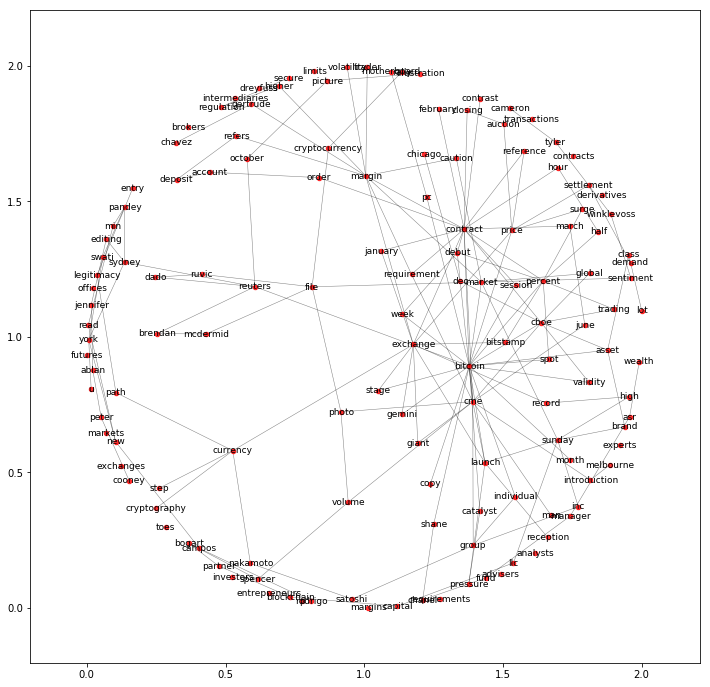

In [4]:
import nltk
import numpy as np
import re
from nltk.tokenize import RegexpTokenizer
import collections
import networkx as nx
import scipy.sparse as sps    
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

with open("reuters.txt") as fin:
    raw = fin.read()
    
raw = re.sub(r'\d+', '', raw)
tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(raw)
postags = nltk.pos_tag(tokens)
#print(postags)
text= nltk.Text(tokens)
words = [w.lower() for w in text]
wnl = nltk.WordNetLemmatizer()
words = [words[k] for k in np.arange(len(words)) if ("ADJ" in postags[k][1]) or ("NN" in postags[k][1])]
#words= [wnl.lemmatize(w) for w in words]
print(len(words)) # COOL!

wordList=np.unique(words)

wordList_filtered = np.array([word for word in wordList if word not in set(nltk.corpus.stopwords.words('english'))])
#wordList_filtered = np.array([word for word in wordList_filtered if word not in set(nltk.corpus.stopwords.words('english'))])
print(wordList_filtered)

w = 2

Adj_mat = sps.lil_matrix((len(wordList_filtered),len(wordList_filtered)),dtype="float64")

for i in np.arange(len(words)):
    src=np.where(wordList_filtered==wnl.lemmatize(words[i]))
    if(len(src)>0):
        for j in np.arange(i+1,np.min([i+w,len(words)])):
            dest=np.where(wordList_filtered==wnl.lemmatize(words[j]))
            if(len(dest)>0):
                if(not src == dest):
                    try:
                        Adj_mat[src,dest]=Adj_mat[src,dest]+1
                        Adj_mat[dest,src]=Adj_mat[dest,src]+1#undirected graph
                    except:
                        Adj_mat[src,dest]=1
                        Adj_mat[dest,src]=1
                    #print(src,dest)
        
Adj_mat = sps.csr_matrix(Adj_mat)

print(Adj_mat.nnz)
gow = nx.Graph(Adj_mat)

N=Adj_mat.shape[0]#number of nodes

f, ax = plt.subplots(figsize=(12,12))

pos=nx.spring_layout(gow,scale = 2)# k= 1/np.sqrt(N)*35,iterations=710,weight=0.1) # positions for all nodes

nx.draw_networkx_nodes(gow,pos,
                       node_list=np.arange(len(wordList_filtered)),
                       node_color='r',
                       node_size=20,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(gow,pos,width=0.5,arrows=False,alpha=0.5)



# some math labels
nx.draw_networkx_labels(gow,pos,dict(zip(np.arange(len(wordList_filtered)),wordList_filtered)),font_size=9)
print("READY")#to suppress output



In [25]:
def superclust(simmat, concepts, mu): # wordList_filtered
    #print(simmat.shape[0], simmat.shape[1])
    N = len(concepts)
    numappeared = np.zeros(len(concepts))
    #print(N)
    sw = []
    #ADDREMADD ############################################################## simmat
    z = -1*np.ones((N, N))
    g = np.zeros(N)
    la = np.zeros(N)
    nclust = np.ones(N)
    AS = np.zeros(N)
    for jstart in range(N):
        z[jstart,jstart] = 1
        A = np.zeros(N)  #a(i*, S)
        for i in range(N): #
            sum=0
            for j in range(N):
                if(z[jstart, j]==1):
                    sum+=simmat[i,j]/nclust[jstart]
                    A[i] = simmat[i,j]
        while(1):
            maxA=-100000
            opti=0
            for k in range (N):
                if (A[k]>maxA):
                    maxA=A[k]
                    opti = k
            sumClust=0
            if(z[jstart,opti]*A[opti]<z[jstart, opti]*(la[jstart]/2+mu/2)):
                z[jstart,opti]=-1*z[jstart,opti]
                nclust[jstart] = nclust[jstart]+z[jstart,opti]
                la[jstart] = ((nclust[jstart]-z[jstart,opti])*(nclust[jstart]-z[jstart,opti]-1)*la[jstart]+2*z[jstart,opti]*A[opti]*(nclust[jstart]-z[jstart, opti]))/(nclust[jstart]*(nclust[jstart]-1)) - mu#FIX!
                for i in range(len(concepts)):
                    sum=0
                    for j in range(len(concepts)):
                        if(z[jstart,j]==1):
                            sum+=simmat[i,j]/nclust[jstart]
                    A[i]=((nclust[jstart]-z[jstart, opti])*A[i]+z[jstart, opti]*simmat[i, opti])/nclust[jstart] #FIX!!
            else:
                g[jstart] = la[jstart]*la[jstart]*nclust[jstart]*nclust[jstart]
                for i in range(N):
                    if(z[jstart, i]==1):
                        AS[jstart]+=A[i]/nclust[jstart]
                break
    maxG = -10000
    indG = 0
    for jstart in range(N):
        if(g[jstart]>maxG):
            maxG = g[jstart]
            indG = jstart
            m = la[jstart]
    
    clust = []
    sw_inds = []
    clust_inds = []
    for i in range(len(z)):
        if(z[indG, i]==1):
            numappeared[i]+=1
            #print(concepts[i])
            clust.append(concepts[i])
            clust_inds.append(i)
        else:
            sw.append(concepts[i])
            sw_inds.append(i)
    
    sumA = 0
    for i in range(N):
        for j in range(N):
            sumA+=simmat[i,j]*simmat[i,j]
    gg = maxG*100/sumA
    
    return clust, sw, m, N, gg, sw_inds, clust_inds

In [ ]:
clust, stopwords1, mu1, N1, g1, sw_inds1, clust_inds = superclust(Adj_mat, wordList_filtered, 0)

Adj = Adj_mat.todense()
print(clust)
Adj = np.delete(Adj, sw_inds1, 0)
Adj = np.delete(Adj, sw_inds1, 1)
print(Adj.shape[0], Adj.shape[1])
#words_filtered_2 = [x for x in l1 if x not in l2]
core, stopwords2, mu2, N2, g2, sw_inds2, clust_inds2 = superclust(Adj, clust, mu1)

READY


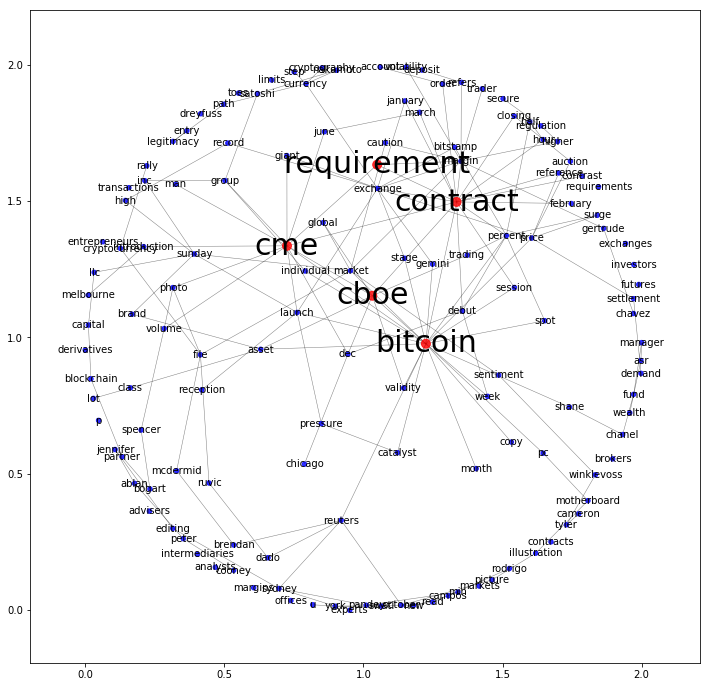

In [83]:
f, ax = plt.subplots(figsize=(12,12))
#print(wordList_filtered)
gow = nx.Graph(Adj_mat)
pos=nx.spring_layout(gow,scale = 2)# k= 1/np.sqrt(N)*35,iterations=710,weight=0.1) # positions for all nodes
color_map = []
size = []
for node in gow:
    if node not in sw_inds1:
        color_map.append('red')
        size.append(80)
    else:
        color_map.append('blue')
        size.append(20)
nx.draw_networkx_nodes(gow,pos,
                       node_list=np.arange(len(wordList_filtered)),
                       node_color = color_map,
                       node_size = size,
                   alpha=0.8)
# edges
nx.draw_networkx_edges(gow,pos,width=0.5,arrows=False,alpha=0.5)

# some math labels
nx.draw_networkx_labels(gow,pos,dict(zip(sw_inds1,wordList_filtered[sw_inds1])),font_size=10)
nx.draw_networkx_labels(gow,pos,dict(zip(clust_inds1,wordList_filtered[clust_inds1])),font_size=30)
print("READY")#to suppress output

In [22]:
import collections
import operator

def text_rank_keywords(raw_text, n_top_keywords = 10):
    raw_text = re.sub(r'\d+', '', raw_text)
    words = nltk.word_tokenize(raw_text)
    words = [word.lower() for word in words if word[0].isalpha()]

    #words = [w.lower() for w in text]
    wnl = nltk.WordNetLemmatizer()
    words = [wnl.lemmatize(w) for w in words]

    wordList=np.unique(words)
    wordList_filtered = np.array([word for word in wordList if word not in set(nltk.corpus.stopwords.words('english'))])

    tagged = nltk.pos_tag(wordList_filtered)


    def filter_for_tags(tagged, tags=['NN', 'JJ', 'NNP']):
        return [item for item in tagged if item[1] in tags]

    tagged = filter_for_tags(tagged)
    wordList_filtered = np.array(list(map(lambda x : x[0], tagged)))

    window_size = 3
    adj_matr = sps.lil_matrix((len(wordList_filtered), len(wordList_filtered)), dtype="float64")

    for i, word in enumerate(words):
        src = np.where(wordList_filtered == words[i])
        if len(src) > 0:
            for j in np.arange(i+1, np.min([i+window_size, len(words)])):
                dest = np.where(wordList_filtered == words[j])
                if len(dest) > 0:
                    try:
                        adj_matr[src, dest] = adj_matr[src, dest] + 1
                    except:
                        adj_matr[src, dest] = 1

    adj_matr = sps.csr_matrix(adj_matr)
    """
    graph = nx.Graph(adj_matr)
    textrank = nx.pagerank(graph)

    sorted_by_rank = sorted(textrank.items(), key=operator.itemgetter(1))
    keywords = list(map(lambda x : x[0], sorted_by_rank[:-n_top_keywords-1:-1]))
    textrank = list(textrank.values())
    """
    return adj_matr, wordList_filtered #wordList_filtered[np.array(keywords)], (textrank, adj_matr, wordList_filtered)

In [9]:
from dataset_500 import DataReader
dataset = DataReader().fetch_data()
x, y = dataset.train_data

Data loading started...
data has been loaded!


In [50]:
snum = 0
sjac = 0
N_doc = len(x)
for i in range(N_doc):
    Adj_mat, wordList_filtered = text_rank_keywords(x[i])
    clust, stopwords1, mu1, N1, g1, sw_inds1, clust_inds = superclust(Adj_mat, wordList_filtered, 0)
    
    snum += len(set(map(lambda x : x.lower(), y[i])) & set(clust))
    real_ans = set(map(lambda x : x.lower(), y[i]))
    sjac += len(real_ans & set(clust))/len(real_ans | set(clust))
    if(i%25==0): print(i)
print("Number of words:", snum/N_doc)
print("Jaccard Index for cluster:", sjac/N_doc)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
Number of words: 0.9577777777777777
Jaccard Index for cluster: 0.02309266951759138


# Spectral

In [49]:
from sklearn.cluster import SpectralClustering
snum = 0
sjac = 0
N_doc = len(x)
for i in range(N_doc):
    Adj_mat, wordList_filtered = text_rank_keywords(x[i])
    sc = SpectralClustering(2, affinity='precomputed', n_init=100, assign_labels='discretize')
    sc.fit(Adj_mat)
    inds = np.where(sc.labels_ > 0 )
    clust = wordList_filtered[inds]
    
    snum += len(set(map(lambda x : x.lower(), y[i])) & set(clust))
    real_ans = set(map(lambda x : x.lower(), y[i]))
    sjac += len(real_ans & set(clust))/len(real_ans | set(clust))
    
print("Number of words ", snum/N_doc)
print("Jaccard index ", sjac/N_doc)

C:\Users\Ivan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:709: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
C:\Users\Ivan\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Ivan\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:100: RuntimeWarning: invalid value encountered in true_divide
  vectors = vectors / np.sqrt((vectors ** 2).sum(axis=1))[:, np.newaxis]


Number of words  6.131111111111111
Jaccard index  0.0733456371623623
